In [19]:
import numpy as np
import matplotlib.pyplot as plt
import torchaudio
import torchaudio.transforms as T
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import src.models
import src.spectrograms as spec
import src.utils as utils
import src.init as init

In [20]:
file_name  = "take-five-short"
audio_file = f"dataset/audios/{file_name}.wav"
midi_file  = f"dataset/midis/{file_name}.mid"
waveform, sample_rate = torchaudio.load(audio_file)

# Convert to mono if stereo
# if waveform.shape[0] > 1:
#     waveform = waveform.mean(dim=0, keepdim=True)
#     waveform = waveform.squeeze(0)

## Getting the spectrogram

### STFT Spectrogram

In [21]:
n_fft           = 1024
hop_length      = 512
min_mag         = 1e-5

spec_stft, spec_np, times_stft, freq_stft = spec.stft_spec(waveform, sample_rate, n_fft, hop_length, min_mag)

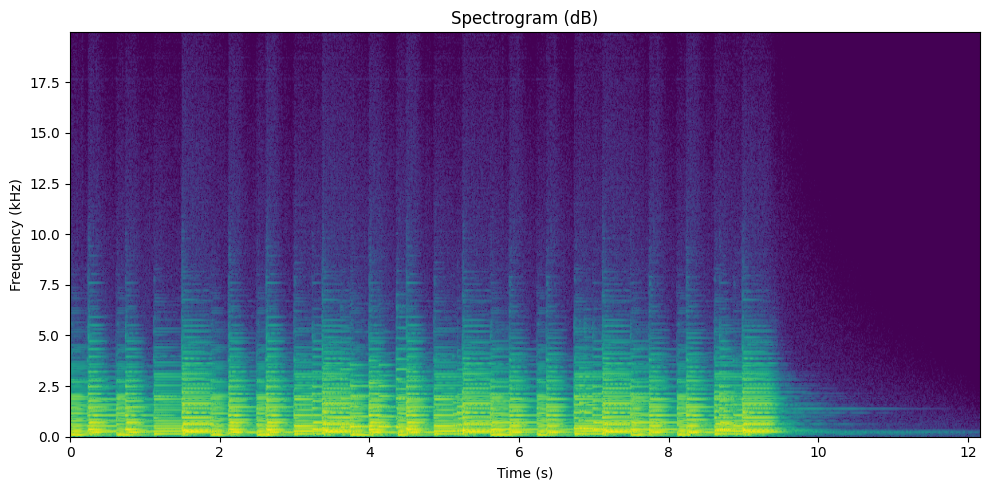

In [22]:
min_freq = 0
max_freq = 20*1e3

spec.vis_spectrogram(spec_stft, times_stft, freq_stft, 0, times_stft[-1], min_freq, max_freq)

Folding over in the 22-25 kHz range due to the sample rate (48kHz)

$\to$ Applying a lowpass filter to attenuate it (attenuate everything over $\frac{sample\_rate}{2}$)

In [23]:
# cutoff_freq = 21000
# nyquist_rate = sample_rate / 2
# normalized_cutoff = cutoff_freq / nyquist_rate
# order = 4
# b, a = scipy.signal.butter(order, normalized_cutoff, btype='low')
# filtered_waveform = torch.tensor(scipy.signal.lfilter(b, a, waveform.numpy(), axis=-1))

# filtered_spec, filtered_spec_np, times, frequencies = spec.stft_spec(filtered_waveform, sample_rate, n_fft, hop_length, min_mag)
# spec.vis_spectrogram(filtered_spec_np, times, frequencies, 0, times_stft[-1], min_freq, max_freq)

### CQT Spectrogram

In [24]:
n_fft           = 1024
hop_length      = 128

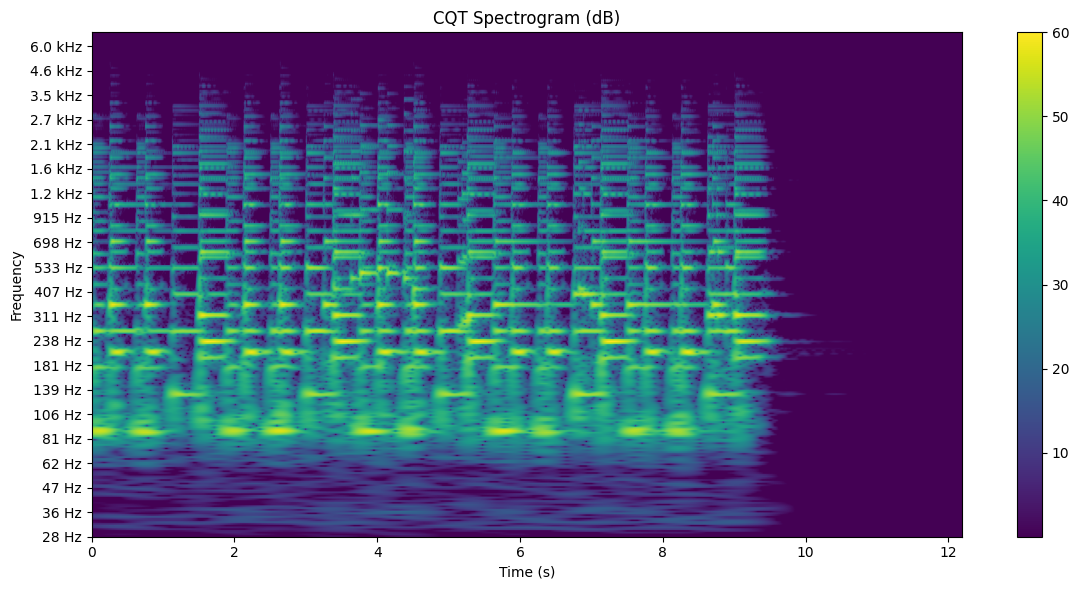

In [25]:
spec_cqt, times_cqt, freq_cqt = spec.cqt_spec(waveform, sample_rate, hop_length)
spec.vis_cqt_spectrogram(spec_cqt, times_cqt, freq_cqt, 0, times_cqt[-1])

### ERB Spectrogram

In [26]:
# spec_erb, times_erb, freqs_erb = spec.erb_spec(waveform, sample_rate, hop_length=hop_length)
# spec.vis_erb_spectrogram(spec_erb, freqs_erb, times, start=0, stop=times[-1])

### GroundTruth midi file

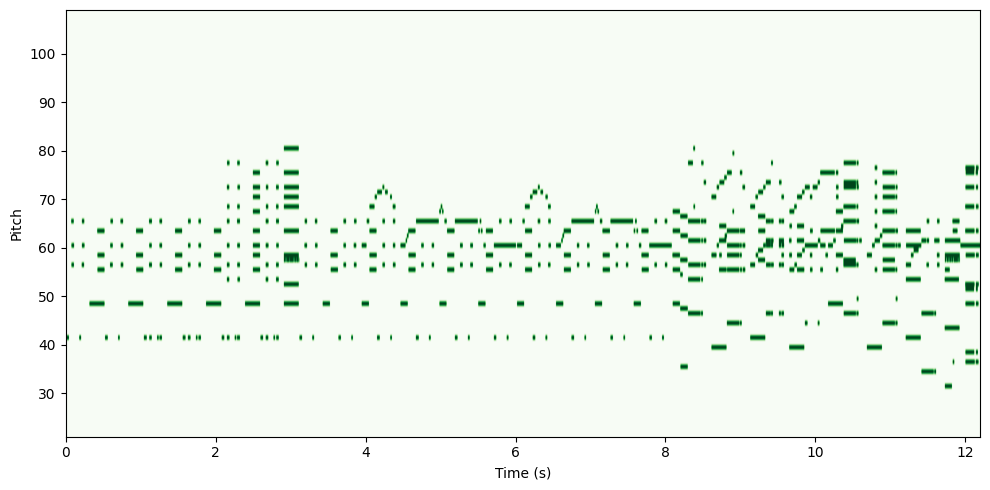

In [27]:
midi_path           = "test-data/take-five.mid"
midi, times_midi    = spec.midi_to_pianoroll(midi_path, waveform, times_cqt, hop_length, sample_rate)
spec.vis_midi(midi, times_midi, 0, times_midi[-1])

## Unrolled NMF

M ≈ WH 

**M** : CQT spectrogram (`spec_cqt`), **W** : dictionnary of notes, **H** : notes activations, **l** : number of different notes to detect

In [28]:
# Init
M           = spec_cqt
n_sources   = 1
l           = n_sources*88
f           = M.shape[0]
t           = M.shape[1]
n_iter      = 5

In [29]:
print(f"input spectrogram: {M.shape}")
print(f"number of notes to be split: {l}")
print(f"number of frequency bins: {f}")
print(f"number of time bins: {t}")

input spectrogram: (288, 4575)
number of notes to be split: 88
number of frequency bins: 288
number of time bins: 4575


### Iterative MU
Requires pretrained Aw and Ah

In [30]:
W, H, M_hat = src.models.MU_iter(M, l, f, t, n_iter)

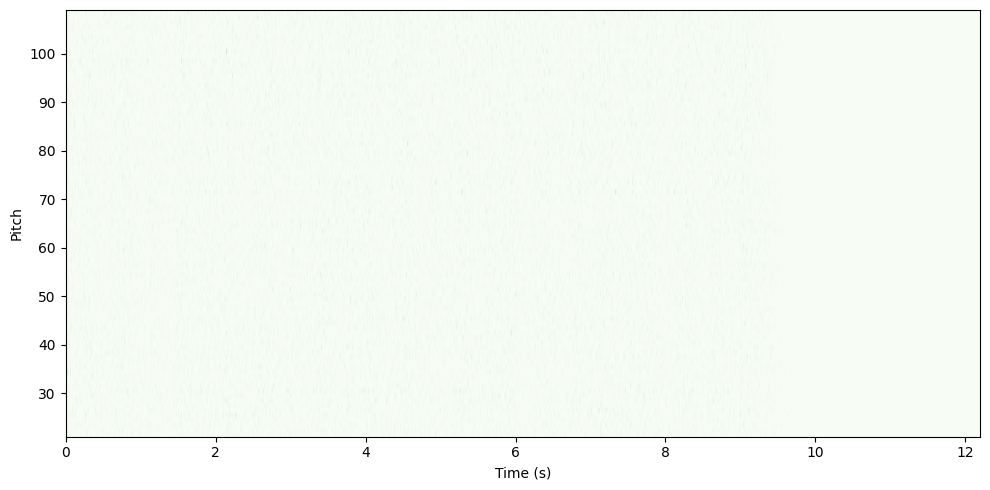

In [31]:
spec.vis_midi(H[-1,:,:].detach().numpy(), times_cqt, times_cqt[0], times_cqt[-1])

### Unrolled RALMU

In [32]:
eps     = 1e-5
model   = src.models.RALMU(f, t, l=l, n_iter=n_iter, shared=True, eps=eps)
device  = torch.device('cpu')
model.to(device=device)

initialized W and H


RALMU(
  (layers): ModuleList(
    (0-4): 5 x RALMU_block2(
      (Aw): Aw_cnn(
        (conv1): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,))
        (conv2): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (conv3): Conv1d(32, 1, kernel_size=(3,), stride=(1,), padding=(1,))
        (relu): ReLU()
        (sigmoid): Sigmoid()
      )
      (Ah): Ah_cnn(
        (conv1): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=(2,))
        (conv2): Conv1d(64, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (conv3): Conv1d(32, 1, kernel_size=(1,), stride=(1,))
        (relu): ReLU()
        (sigmoid): Sigmoid()
      )
    )
  )
)

In [33]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params

13250

- **Init** W

In [34]:
single_note = "test-data/single-notes"
W, freqs = init.init_W(single_note)
pitches, notes, W = init.W_to_pitch(W, freqs)

/Users/edabier/Documents/Stage-Fin-etudes/Stage-Telecom-Paris/AMT_codebase/amt_venv/lib/python3.10/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=690
  warnings.warn(
/Users/edabier/Documents/Stage-Fin-etudes/Stage-Telecom-Paris/AMT_codebase/Unrolled-NMF/src/init.py:94: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  frequency = torch.tensor(frequency, dtype=torch.float32)


- **Load** the dataset

In [35]:
dataset = src.utils.MaestroNMFDataset("dataset/audios", "dataset/midis")
loader  = DataLoader(dataset, batch_size=1, shuffle=True)

- **Train** the model

In [36]:
n_epochs    = 30
optimizer   = torch.optim.Adam(model.parameters(), lr=1e-3)

Losses: onset= 0.8212319612503052, offset= 0.8056915998458862, pitch= 9.621936798095703, total= 11.248860359191895, normalized= 2.7940537620452233e-05
Epoch 1, Loss: 2210.8845
Losses: onset= 0.8212319612503052, offset= 0.8056915998458862, pitch= 9.621936798095703, total= 11.248860359191895, normalized= 2.7940537620452233e-05
Epoch 2, Loss: 1751.2845
Losses: onset= 0.8212319612503052, offset= 0.8056915998458862, pitch= 9.621936798095703, total= 11.248860359191895, normalized= 2.7940537620452233e-05
Epoch 3, Loss: 1450.2349
Losses: onset= 0.8212319612503052, offset= 0.8056915998458862, pitch= 9.621936798095703, total= 11.248860359191895, normalized= 2.7940537620452233e-05
Epoch 4, Loss: 1322.4551
Losses: onset= 0.8212319612503052, offset= 0.8056915998458862, pitch= 9.621936798095703, total= 11.248860359191895, normalized= 2.7940537620452233e-05
Epoch 5, Loss: 1240.9929
Losses: onset= 0.8212319612503052, offset= 0.8056915998458862, pitch= 9.621936798095703, total= 11.248860359191895, norm

Text(0.5, 0, 'Epochs')

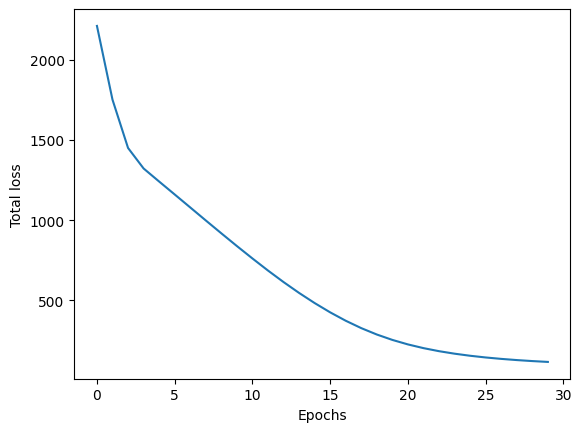

In [37]:
loss = src.utils.train(n_epochs, model, optimizer, loader, device, notes)

plt.plot(loss)
plt.ylabel("Total loss")
plt.xlabel("Epochs")